In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import gymnasium as gym
env = gym.make("ALE/KungFuMaster-v5")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [24]:
def transform(state):
    return torch.from_numpy(state).permute(2, 1, 0).float() / 255.0

def readhealth(state):
    return (state[45, 50:82, 1] > 128).astype(float).mean()

def rollout(env, agent, max_steps=1000):
    result = []
    state, info = env.reset()
    state = transform(state)
    health = info['lives']
    for _ in range(max_steps):
        action = agent(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        next_health = 0 if info['lives'] == 0 else (info['lives'] - 1) + readhealth(next_state)
        reward += (next_health - health) * 100 # penalize health loss

        result.append((state, action, reward))
        state = transform(next_state)
        health = next_health
        if terminated or truncated:
            break
    return result

total_games = 0

def batches(env, agent, batch_size=32, num_batches=100, max_steps=1000, reward_discount=0.99):
    games = []
    gamea = []
    gamer = []
    while num_batches > 0:
        while len(games) < batch_size:
            game = rollout(env, agent, max_steps)
            total_games += 1
            # score using discounted rewards
            acc_reward = 0
            for i in range(len(game) - 1, -1, -1):
                acc_reward = game[i][2] + reward_discount * acc_reward
                games.append(game[i][0])
                gamea.append(game[i][1])
                gamer.append(acc_reward)

        yield games[:batch_size], gamea[:batch_size], gamer[:batch_size]
        games = games[batch_size:]
        gamea = gamea[batch_size:]
        gamer = gamer[batch_size:]
        num_batches -= 1

In [5]:
class AtariNet(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(torch.prod(torch.tensor(o.size())))

    def forward(self, x):
        conv_out = self.conv(x)
        # flatten each sample in the batch
        conv_out = conv_out.view(x.shape[0], -1) if len(x.shape) == 4 else conv_out.flatten()
        pred = self.fc(conv_out)
        return pred

Epoch 0 took 18.02s, reward: 26.37, loss: 70.65
Epoch 1 took 17.88s, reward: 35.55, loss: 92.28
Epoch 2 took 16.63s, reward: 64.97, loss: 162.38
Epoch 3 took 17.44s, reward: 58.22, loss: 131.88
Epoch 4 took 17.87s, reward: 33.45, loss: 68.91
Epoch 5 took 16.95s, reward: 123.82, loss: 211.41
Epoch 6 took 16.82s, reward: 134.80, loss: 172.02
Epoch 7 took 17.10s, reward: 200.19, loss: 240.65
Epoch 8 took 17.12s, reward: 212.65, loss: 223.37
Epoch 9 took 17.04s, reward: 148.37, loss: 198.88
Epoch 10 took 17.58s, reward: 151.60, loss: 202.63
Epoch 11 took 17.06s, reward: 189.14, loss: 214.61
Epoch 12 took 17.69s, reward: 183.71, loss: 198.75
Epoch 13 took 17.62s, reward: 140.18, loss: 172.00
Epoch 14 took 17.38s, reward: 195.78, loss: 210.77
Epoch 15 took 17.24s, reward: 209.85, loss: 204.67
Epoch 16 took 17.08s, reward: 174.31, loss: 195.66
Epoch 17 took 17.04s, reward: 164.74, loss: 219.81
Epoch 18 took 17.48s, reward: 159.09, loss: 172.62
Epoch 19 took 17.30s, reward: 125.09, loss: 116.6

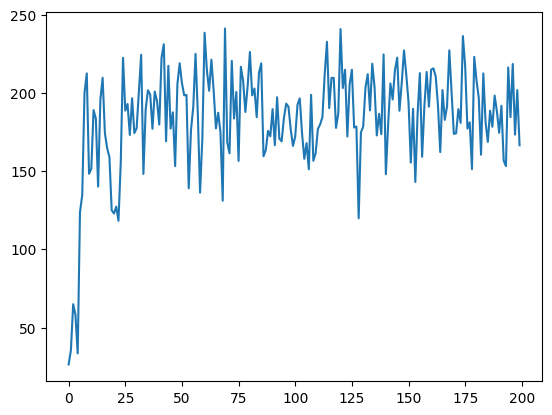

In [25]:
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AtariNet((3, 160, 210), env.action_space.n)
net = net.to(device)

def agent(state):
    state = state.to(device)
    pred = net(state)
    assert(len(pred.shape) == 1)
    prob = F.softmax(pred, dim=0)
    act = torch.multinomial(prob, 1)
    return act.item() # pred.argmax().item()

optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)

total_games = 0
num_epochs = 200
num_batches = 100
batch_size = 128

epoch_rewards = []

for epoch in range(num_epochs):
    epoch_reward = 0
    epoch_loss = 0
    epoch_start = time.time()

    for bs, ba, br in batches(env, agent, batch_size=batch_size, num_batches=num_batches):
        bs = torch.stack(bs)
        ba = torch.tensor(ba, dtype=torch.long)
        br = torch.tensor(br, dtype=torch.float)

        bs, ba, br = bs.to(device), ba.to(device), br.to(device)

        pred = net(bs)
        log_prob = F.log_softmax(pred, dim=-1)
        loss = (-log_prob[torch.arange(0, ba.shape[0]), ba] * br).mean()

        epoch_reward += br.mean().item()
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_reward /= num_batches
    epoch_loss /= num_batches

    print(f'Epoch {epoch} took {time.time() - epoch_start:.2f}s, reward: {epoch_reward:.2f}, loss: {epoch_loss:.2f}')

    epoch_rewards.append(epoch_reward)

    torch.save(net.state_dict(), 'kungfu.pth')

plt.plot(epoch_rewards)

print(f'{total_games} games played')

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = AtariNet((3, 160, 210), env.action_space.n).to(device)
net.load_state_dict(torch.load('kungfu.pth', weights_only=True))

testenv = gym.make("ALE/KungFuMaster-v5", render_mode=None)
observation, info = testenv.reset()
total_reward = 0

while True:
    action = agent(transform(observation))
    observation, reward, terminated, truncated, info = testenv.step(action)
    total_reward += reward

    if terminated or truncated:
        break

testenv.close()

print(f'Total reward: {total_reward}')

Total reward: 5600.0
